In [73]:
import numpy as np
from numpy import expand_dims, zeros, ones, asarray
from numpy.random import randn, randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Input, Embedding, Concatenate
import matplotlib.pyplot as plt
import matplotlib

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
os.listdir("./")
os.listdir("./drive/MyDrive/new_generation")

['conditional_GAN.h5', 'model']

In [5]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [6]:
def define_generator(latent_dim, n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

In [7]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [8]:
# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

In [9]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

In [10]:
D_loss1_per_epoch=[]
D_loss2_per_epoch=[]
G_loss_per_epoch=[]

D_loss1_per_batch_per_epoch=[]
D_loss2_per_batch_per_epoch=[]
G_loss_per_batch_per_epoch=[]

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            D_loss1_per_batch_per_epoch.append(d_loss1) 
            D_loss2_per_batch_per_epoch.append(d_loss2)
            G_loss_per_batch_per_epoch.append(g_loss)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        
        D_loss1_per_epoch.append(d_loss1) 
        D_loss2_per_epoch.append(d_loss2)
        G_loss_per_epoch.append(g_loss)
    # save the generator model
    g_model.save("./drive/MyDrive/new_generation/model/conditional_GAN.h5")

In [11]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
>90, 149/468, d1=0.675, d2=0.689 g=0.749
>90, 150/468, d1=0.659, d2=0.689 g=0.795
>90, 151/468, d1=0.669, d2=0.642 g=0.810
>90, 152/468, d1=0.699, d2=0.666 g=0.766
>90, 153/468, d1=0.653, d2=0.696 g=0.789
>90, 154/468, d1=0.701, d2=0.665 g=0.751
>90, 155/468, d1=0.679, d2=0.674 g=0.756
>90, 156/468, d1=0.669, d2=0.659 g=0.758
>90, 157/468, d1=0.645, d2=0.667 g=0.753
>90, 158/468, d1=0.682, d2=0.696 g=0.758
>90, 159/468, d1=0.671, d2=0.620 g=0.797
>90, 160/468, d1=0.661, d2=0.708 g=0.789
>90, 161/468, d1=0.665, d2=0.667 g=0.790
>90, 162/468, d1=0.626, d2=0.653 g=0.789
>90, 163/468, d1=0.683, d2=0.698 g=0.796
>90, 164/468, d1=0.717, d2=0.655 g=0.801
>90, 165/468, d1=0.681, d2=0.683 g=0.781
>90, 166/468, d1=0.720, d2=0.654 g=0.758
>90, 167/468, d1=0.727, d2=0.664 g=0.796
>90, 168/468, d1=0.678, d2=0.669 g=0.802
>90, 169/468, d1=0.699, d2=0.640 g=0.855
>90, 170/468, d1=0.654, d2=0.668 g=0.783
>90, 171/468, d1=0.6

In [74]:
#Show the Generator-Descriminator loss for every epoch
def plot_gan_losses_per_epoch(G_loss, D_loss1, D_loss2):
    plt.plot(G_loss)
    plt.plot(D_loss1)
    plt.plot(D_loss2)
    plt.title('GAN Loss evolution')
    plt.ylabel('')
    plt.xlabel('epoch')
    plt.legend(['Generator', 'Discriminator1', 'Discriminator2'], loc='upper left')
    plt.show()

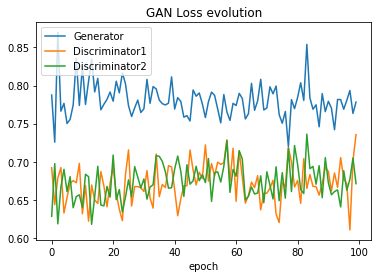

In [75]:
plot_gan_losses_per_epoch(G_loss_per_epoch, D_loss1_per_epoch, D_loss2_per_epoch)

In [76]:
#Show the Generator-Descriminator loss for every batch
def plot_gan_losses_per_batch(G_loss, D_loss1, D_loss2):
    plt.plot(G_loss)
    plt.plot(D_loss1)
    plt.plot(D_loss2)
    plt.title('GAN Loss evolution')
    plt.ylabel('')
    plt.xlabel('batch')
    plt.legend(['Generator', 'Discriminator1', 'Discriminator2'], loc='upper left')
    plt.show()

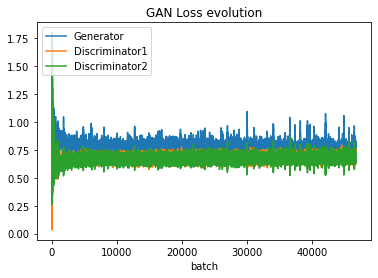

In [77]:
plot_gan_losses_per_batch(G_loss_per_batch_per_epoch, D_loss1_per_batch_per_epoch, D_loss2_per_batch_per_epoch)

In [78]:
# create and save a plot of generated images
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        fig=plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
        plt.imsave("./drive/MyDrive/new_generation/img/100_sample/sample_100_all_category_%d.png" %(i), examples[i, :, :, 0], cmap='gray_r')
    plt.show()

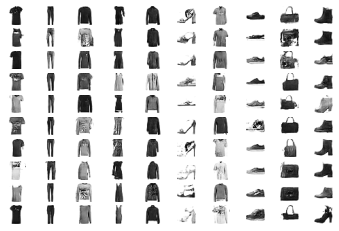

In [79]:
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = g_model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)

In [80]:
def generate_latent_points_10_image(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
	return [z_input, labels]

def save_plot_10_image(examples, n):
    # plot images
    for i in range(n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
        plt.imsave("./drive/MyDrive/new_generation/img/10_sample/sample_10_all_category_%d.png" %(i), examples[i, :, :, 0], cmap='gray_r')
    plt.show()

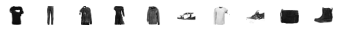

In [81]:
# generate images
latent_points, labels = generate_latent_points_10_image(100, 10)
# specify labels
X  = g_model.predict([latent_points, labels])
#print(X.shape)
X = (X + 1) / 2.0
# plot the result
save_plot_10_image(X, 10)

In [82]:
def generate_latent_points_one_image(latent_dim, n_samples, lab, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
 # generate labels
	labels=np.array([lab])
	return [z_input, labels]

def save_plot_one_image(examples, n):
    # plot images
    for i in range(n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
        plt.imsave("./drive/MyDrive/new_generation/img/one_sample/img_generated.png", examples[i, :, :, 0], cmap='gray_r')
    plt.show()

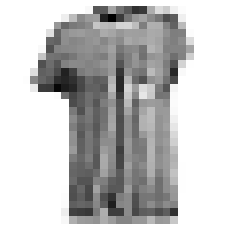

In [89]:
# generate images
latent_points, labels = generate_latent_points_one_image(100, 1, 0)
# specify labels
X  = g_model.predict([latent_points, labels])
#print(X.shape)
X = (X + 1) / 2.0
# plot the result
save_plot_one_image(X, 1)